# Modelo para prever a demanda por cimento quantitativamente

Versão refatorada que tenta prever os valores da **demanda**, e não a tendência

Nesse notebook carregamos os dados de `TCC/dados/anualizados/csv/` e implementamos uma rede feed forward simples para prever a demanda por cimento de acordo com o estado

Definimos um range de tempo  de janeiro do ano 1991 até dezembro de 2019, adotamos a variável `anomes` para indicar tempo: `199101 <= anomes <= 201912`

Supomos, sempre, que os estados estão ordenado sem ordem alfabética nas tabelas. Além disso, supomos que a primeira coluna da tabela indica a medição janeiro de 1991 (anomes = 199101) e a última, dezembro de 2019 (anomes = 201912), com frequência mensal.

## Carregando as libs, métodos e funções



### Importando as libs

Conectamos o Collab ao Google Drive e importamos os modulos de Python utilizados para o modelo:

- Pandas
- Numpy
- Sklearn
- TensorFlow
- Seaborn
- Matplotlib


In [44]:
# conectamos o Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# importamos as libs
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Declaração de funções

Aqui definimos as funções utilizadas para o data prep, treinamento do modelo, cálculo de erros e visualização de dados

In [46]:
# devolve um array com os valores de ano e mes considerados no modelo
# de janeiro de ANO_INICIAL=1991 ate dezembro de ANO_FINAL=2019
def get_anomes ():

    anos = [str(i) for i in range(ANO_INICIAL, ANO_FINAL+1)]

    # colocamos os 0 a esquerda se precisar
    meses = ["{:02d}".format(i) for i in range(1,13)] 

    anomes = []

    for ano in anos:
        anomes += [str(ano) + i for i in meses]

    return anomes

In [47]:
# funcao que pega um pandas dataframe e coloca os valor 
# no array que sera usado como entrada para o  modelo
def df_to_list(indicador, array : list):

    anomes = get_anomes()
  
    index = 0 

    for coluna in anomes:

        for linha in indicador[coluna]:

            array[index] = array[index] + [linha]
            index += 1
    
    return array

In [48]:
# Carrega os dados de consumo de cimento 
# do PATH e
# devolve uma lista com a tendencia de demanda
def get_consumo (path : str) -> list :

    import pandas as pd

    anomes = get_anomes()

    consumo = pd.read_csv(path + "consumo.csv")

    tendencia = []

    for ind in anomes:

        # estados...
        for estado in consumo.index:
        
            tendencia += [float (consumo[ind][estado])]

    return tendencia

In [49]:
# Lê os arquivos csv presentes em 'indicadores' que se encontram no path
# definido na variavel path e carrega no df de entrada, que, na verdade,
# é uma lista
def get_df (path : str, indicadores : list) -> list:

    import pandas as pd

    df = [[i] for i in range(1,28)] * len(get_anomes())

    for ind in indicadores:

      print(f"Carregando o indicador: {ind[:-3]}")
      df = df_to_list(pd.read_csv(path + ind), df)

    return df

## Definimos parâmetros

Aqui definimos os parâmetros utilizados

- `ANO_INICIAL`: ano de início dos dados utilizados para o modelo
- `ANO_FINAL`: último ano dos dados utilizados para o modelo
- `PATH`: caminho no Drive (ou local) onde os dados estão salvos para que o modelo possa consultar e carregá-los
- `INDICADORES`: quais dados utilizamos para treinar o modelo, cada elemento da lista de indicadores corresponde a um arquivo presente no diretório indicado por `PATH`
- `N_STATES`: número de estados do Brasil considerados no modelo
- `ESTADOS`: nome dos estados do Brasil considerados no modelo, na ordem correspondente ao índice presente nos dados

In [50]:
### Constantes que definimos

ANO_INICIAL = 1991
ANO_FINAL = 2019

# PATH = "../dados/anualizados/csv/"
PATH="/content/drive/MyDrive/TCC/dados/anualizados/csv/"

INDICADORES = [
    "consumo.csv",
    "desemprego.csv",
    "estoque.csv",
    "idh_educacao.csv",
    "idh_renda.csv",
    "idh_saude.csv",
    "IGP.csv",
    "INCC.csv",
    "IPCA.csv",
    "NFSP.csv",
    "pib_construcao.csv",
    "pib_per_capita.csv",
    "pib_precos_constantes.csv",
    "pib_precos_mercado_corrente.csv",
    "populacao.csv",
    "SELIC.csv"]

N_STATES=27
ESTADOS = ['Acre', 'Alagoas', 'Amazonas', 'Amapá', 'Bahia', 'Ceará',
  'Distrito Federal', 'Espírito Santo', 'Goiás', 'Maranhão',
  'Minas Gerais', 'Mato Grosso do Sul', 'Mato Grosso', 'Pará', 'Paraíba',
  'Pernambuco', 'Piauí', 'Paraná', 'Rio de Janeiro',
  'Rio Grande do Norte', 'Rondônia', 'Roraima', 'Rio Grande do Sul',
  'Santa Catarina', 'Sergipe', 'São Paulo', 'Tocantins']

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

REGIAO = ['NORTE', 'NORDESTE', 'NORTE', 'NORTE', 'NORDESTE', 'NORDESTE',
  'CENTRO', 'SUDESTE', 'CENTRO', 'NORDESTE',
  'SUDESTE', 'CENTRO', 'CENTRO', 'NORTE', 'NORDESTE',
  'NORDESTE', 'NORDESTE', 'SUL', 'SUDESTE',
  'NORDESTE', 'NORTE', 'NORTE', 'SUL',
  'SUL', 'NORDESTE', 'SUDESTE', 'NORDESTE']

NORTE = [0,2,3,13,20,21]
NORDESTE = [1,4,5,9,14,15,16,19,24,26]
CENTRO = [6,8,11,12]
SUDESTE = [7,10,18,25]
SUL = [17,22,23]

## Carregamos os dados

Aqui é feito o carregamento dos dados, tanto de consumo, quando das variáveis de entrada, com o auxílio dos métodos já definidos.

Os dados de demanda são carregados, transformados em uma lista e armazenados em `tendencia`

Já os dados de entrada são carregados, transformados em um tensor onde cada elemento corresponde às medições de um determinado estado em um mês específico e um ano específico, por exemplo:

`df[0] = [1, (...)]` : corresponde aos indicadores do Acre medidos em janeiro de 1991

In [51]:
# Dados do consumo 
tendencia = get_consumo(PATH)

In [52]:
# Dados de entrada 
df = get_df(PATH, INDICADORES)

Carregando o indicador: consumo.
Carregando o indicador: desemprego.
Carregando o indicador: estoque.
Carregando o indicador: idh_educacao.
Carregando o indicador: idh_renda.
Carregando o indicador: idh_saude.
Carregando o indicador: IGP.
Carregando o indicador: INCC.
Carregando o indicador: IPCA.
Carregando o indicador: NFSP.
Carregando o indicador: pib_construcao.
Carregando o indicador: pib_per_capita.
Carregando o indicador: pib_precos_constantes.
Carregando o indicador: pib_precos_mercado_corrente.
Carregando o indicador: populacao.
Carregando o indicador: SELIC.


## Definindo funções para treinamento do modelo 

`define_model`: define o modelo utilizado, um keras Sequential com função de ativação `relu` e 2 camadas
- `compile_model`: compila o modelo e define o otimizador utilizado (Adam) e a loss (mse), além da métrica utilizada (mse)

In [53]:
# vamos definir o modelo
def define_model ():
  
  # Sequential
  model = keras.Sequential()
  model.add(Dense(17, input_shape=(17,), activation="relu"))
  model.add(Dense(12, activation="relu"))
  model.add(Dense(1))
  
  return model 

In [54]:
def compile_model (model):

  model.compile(optimizer='Adam',
                loss='mse',
                metrics=['mse'])
  return model

## Funções para cálculo e visualição do erro encontrado

Estão definidas aqui as funções para cálculo de erro dos modelos e para visualização dos erros

In [55]:
# calcula o erro de cada previsão 
# retorna o array com os erros
def get_error (real, result):

  from math import sqrt

  mse = 0 
  error = []

  for i in range(len(real)):

    error += [abs(real[i] - result[i])/real[i]]

  print(f"O erro em relação a previsão é de: {100*sqrt(sum([i**2 for i in error]))/len(real):.2f}%")

  return error

In [56]:
# calcula e mostra o grafico do erro com porcentagem
def show_error_percent (error):

  # colocamos em porcentagem
  error_percent = [100*round(i, 1) for i in error]

  error_norm = [0 if i == 1 else i for i in error_percent]
  error_norm = [100 if i > 100 else i for i in error_norm]

  plt.figure(figsize=(20,6))

  plt.xlabel("Porcentagem de erro")
  plt.title("Distribuição do erro percentual")
  
  ax = sns.countplot(x=error_norm, palette="Paired")
  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(error))
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x-0.5, y+5), ha="left")

  plt.ylabel("Número de ocorrencias")

  plt.show()

In [57]:
# Plot do grafico inicial, apenas como backup
def initial_plot(pred, real):

  plt.figure(figsize=(19,6))

  plt.title("Previsão x dado real")


  plt.plot(pred, label="Previsão")
  plt.plot(real, marker=".", color="coral", linestyle=' ', label="Resultado real")
  plt.legend()

  plt.show()

## Treinamento do modelo

Treinamos o mesmo modelo com dois conjuntos de dados distintos:

- separação aleatória dos dados entre treino e teste
- utilizando dados anteriores a um `ANO_BASE` para treinar o modelo e prever a demanda nos anos posteriores

### Treinamento do modelo com split aleatório dos dados

Treinamos o modelo com os dados separados de forma aleatória, com o método `train_test_split` para observar o desempenho da rede e, posteriormente, comparar com o modelo treinado com base nos anos

In [58]:
# separando conjuntos de treino e teste (70% e 30%)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(df, tendencia,test_size=0.3)

In [59]:
# definimos, compilamos e treinamos o modelo
model_random_split = define_model()
model_random_split = compile_model(model_random_split)
model_random_split.fit(X_train_random, y_train_random, epochs=10) 

Epoch 1/10
206/206 [==============================] - 1s 2ms/step - loss: 13932810993664.0000 - mse: 13932810993664.0000
Epoch 2/10
206/206 [==============================] - 0s 2ms/step - loss: 2090805362688.0000 - mse: 2090805362688.0000
Epoch 3/10
206/206 [==============================] - 0s 2ms/step - loss: 733326802944.0000 - mse: 733326802944.0000
Epoch 4/10
206/206 [==============================] - 0s 2ms/step - loss: 347371667456.0000 - mse: 347371667456.0000
Epoch 5/10
206/206 [==============================] - 0s 2ms/step - loss: 177826529280.0000 - mse: 177826529280.0000
Epoch 6/10
206/206 [==============================] - 0s 2ms/step - loss: 195372908544.0000 - mse: 195372908544.0000
Epoch 7/10
206/206 [==============================] - 0s 2ms/step - loss: 3902154473472.0000 - mse: 3902154473472.0000
Epoch 8/10
206/206 [==============================] - 0s 2ms/step - loss: 416109068288.0000 - mse: 416109068288.0000
Epoch 9/10
206/206 [==============================] - 0s

In [60]:
# Métrica simples de avaliacao
test_loss, test_acc = model_random_split.evaluate(X_test_random,  y_test_random, verbose=2)

89/89 - 0s - loss: 57271762944.0000 - mse: 57271762944.0000 - 250ms/epoch - 3ms/step


### Previsão e desempenho

In [61]:
# previsao
predictions_random_split = model_random_split.predict(X_test_random)
pred_random_split = [i[0] for i in predictions_random_split]

89/89 [==============================] - 0s 2ms/step


In [62]:
error_random_split = get_error(y_test_random, pred_random_split)

O erro em relação a previsão é de: 5.19%


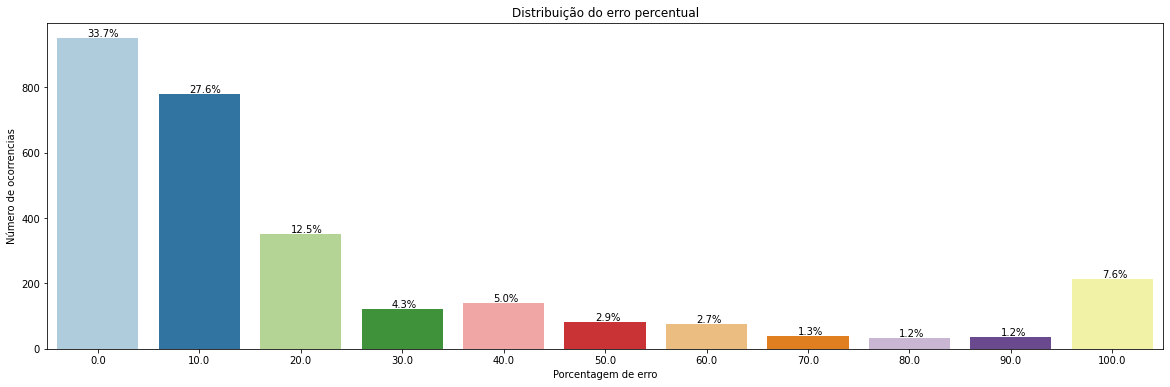

In [63]:
show_error_percent(error_random_split)

### Treinamento com dados anteriores a um `ANO_BASE`



In [64]:
# definimos o ano_base
ANO_BASE = 2015

In [65]:
# função que separa os dados anteriores a um ano 
def split_data (x : list, y : list, year) -> tuple:

  anos = year - ANO_INICIAL
  meses = 12
  estados = 27

  return (x[:anos*meses*estados], x[anos*meses*estados:]),(y[:anos*meses*estados], y[anos*meses*estados:])

In [66]:
# separamos os dados em treino e teste
size = len(tendencia)
((x_train_anual, x_test_anual), (y_train_anual, y_test_anual)) = split_data(df, tendencia, ANO_BASE)

In [67]:
model_anual = define_model()

In [68]:
model_anual = compile_model(model_anual)

In [69]:
model_anual.fit(x_train_anual, y_train_anual, epochs=25) 

Epoch 1/25
243/243 [==============================] - 1s 3ms/step - loss: 112448736591872.0000 - mse: 112448736591872.0000
Epoch 2/25
243/243 [==============================] - 1s 2ms/step - loss: 6281578414080.0000 - mse: 6281578414080.0000
Epoch 3/25
243/243 [==============================] - 1s 2ms/step - loss: 2974986272768.0000 - mse: 2974986272768.0000
Epoch 4/25
243/243 [==============================] - 1s 2ms/step - loss: 770632056832.0000 - mse: 770632056832.0000
Epoch 5/25
243/243 [==============================] - 1s 2ms/step - loss: 254042128384.0000 - mse: 254042128384.0000
Epoch 6/25
243/243 [==============================] - 1s 2ms/step - loss: 160887865344.0000 - mse: 160887865344.0000
Epoch 7/25
243/243 [==============================] - 0s 2ms/step - loss: 100983463936.0000 - mse: 100983463936.0000
Epoch 8/25
243/243 [==============================] - 1s 2ms/step - loss: 70372974592.0000 - mse: 70372974592.0000
Epoch 9/25
243/243 [==============================] - 1s

In [70]:
# Avaliacao
test_loss, test_acc = model_anual.evaluate(x_test_anual,  y_test_anual, verbose=2)

51/51 - 0s - loss: 163255648256.0000 - mse: 163255648256.0000 - 216ms/epoch - 4ms/step


In [71]:
# previsao
predictions_anual = model_anual.predict(x_test_anual)
pred_anual = [i[0] for i in predictions_anual]

51/51 [==============================] - 0s 1ms/step


In [72]:
error_anual = get_error(y_test_anual, pred_anual)

O erro em relação a previsão é de: 4.47%


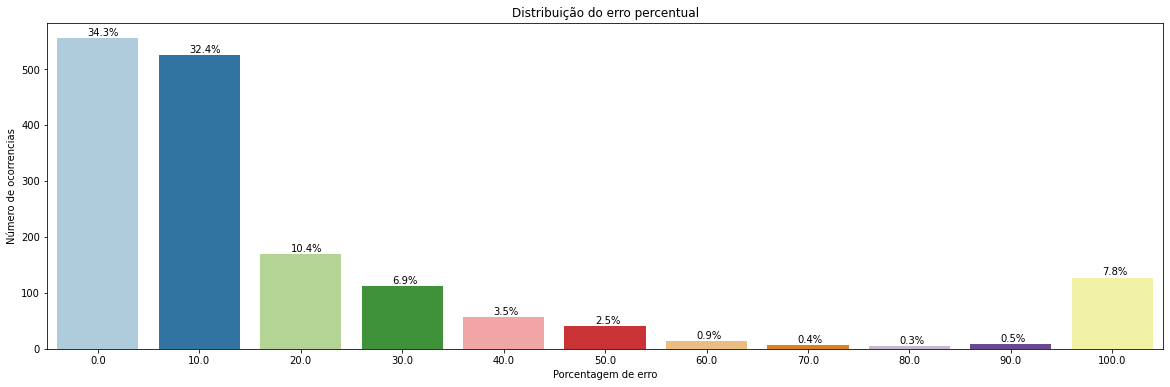

In [73]:
show_error_percent(error_anual)

## Análise das previsões

Apesar de prevermos com granularidade mensal, vamos mostrar gráficos anuais para melhor visibilidade

In [74]:
df_consumo = pd.DataFrame([str(i) for i in range(ANO_INICIAL,ANO_FINAL + 1)], columns=["ano"])
df_pred_anual = pd.DataFrame([str(i) for i in range(ANO_BASE,ANO_FINAL + 1)], columns=["ano"])

for i in range(0, N_STATES):

  df_consumo[ESTADOS[i]] = [tendencia[j] for j in range(i,len(tendencia),N_STATES*12)]
  df_pred_anual[ESTADOS[i]] = [pred_anual[j] for j in range(i,len(pred_anual),N_STATES*12)]


In [75]:
def show_pred (state, real, pred):

  plt.figure(figsize=(18,6))

  plt.title(f"Previsão de consumo do estado: {ESTADOS[state]}")
  plt.plot(real["ano"],real[ESTADOS[state]], label="Dado real", color="deepskyblue", linewidth=2)
  plt.plot(pred["ano"],pred[ESTADOS[state]], label="Previsão", color="lightcoral", linewidth=2)

  plt.axvline(x = 24, color = 'gray', linestyle="--")
  plt.legend()

  plt.show()


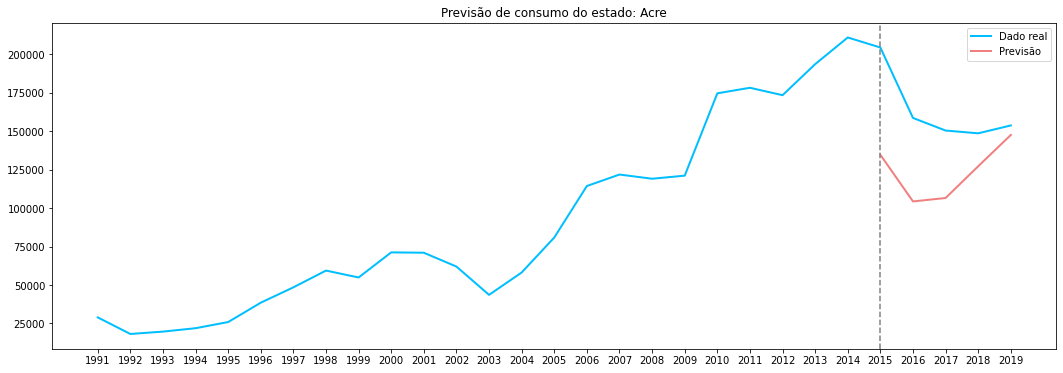

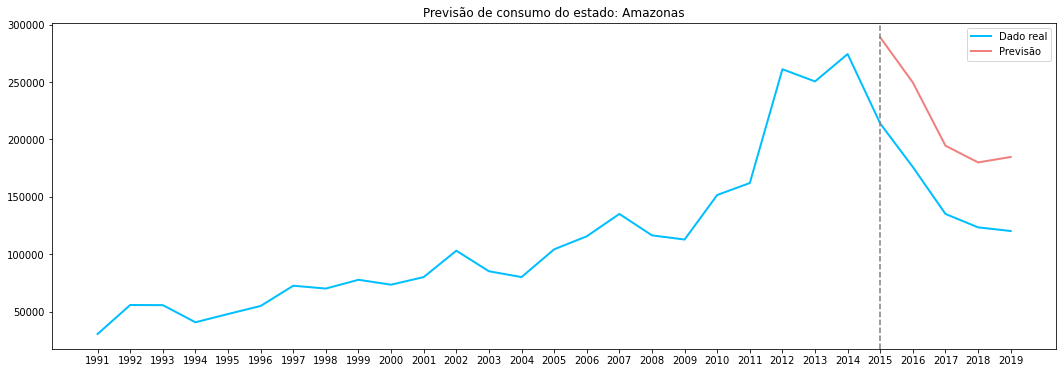

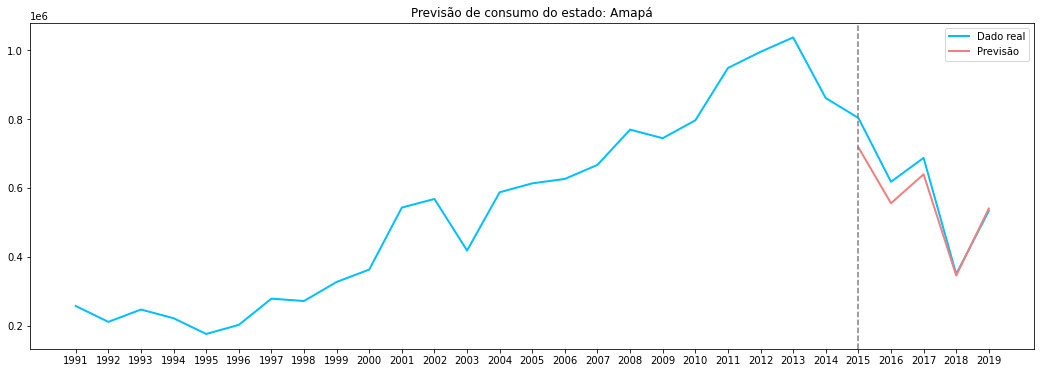

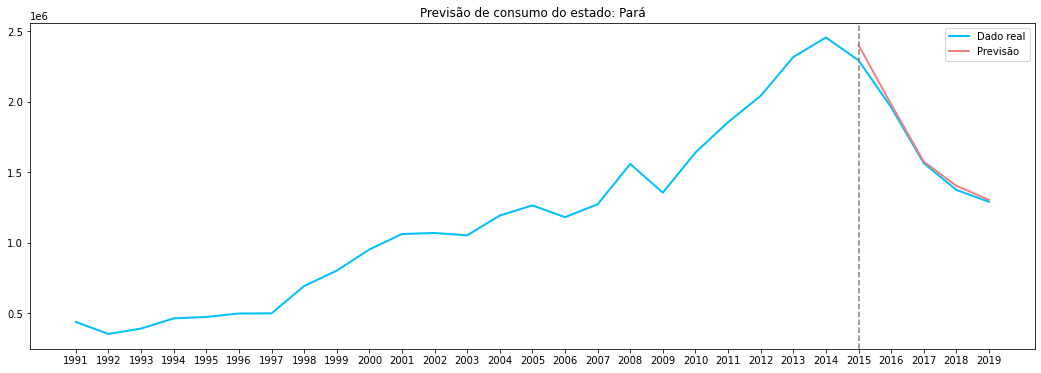

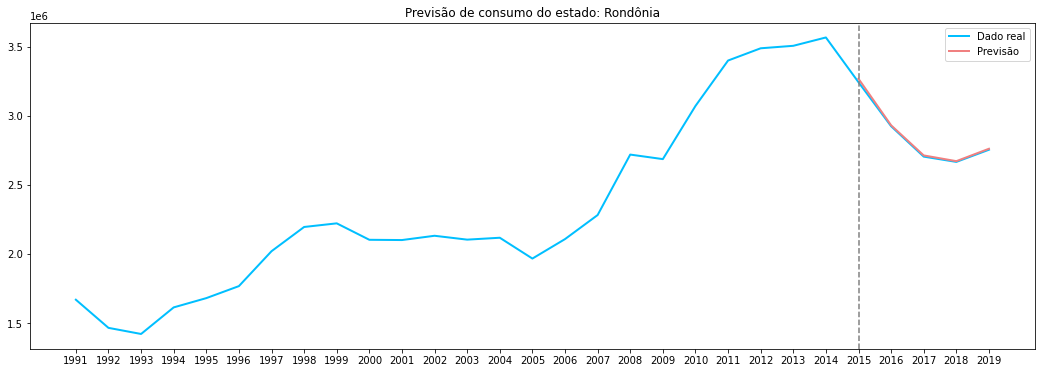

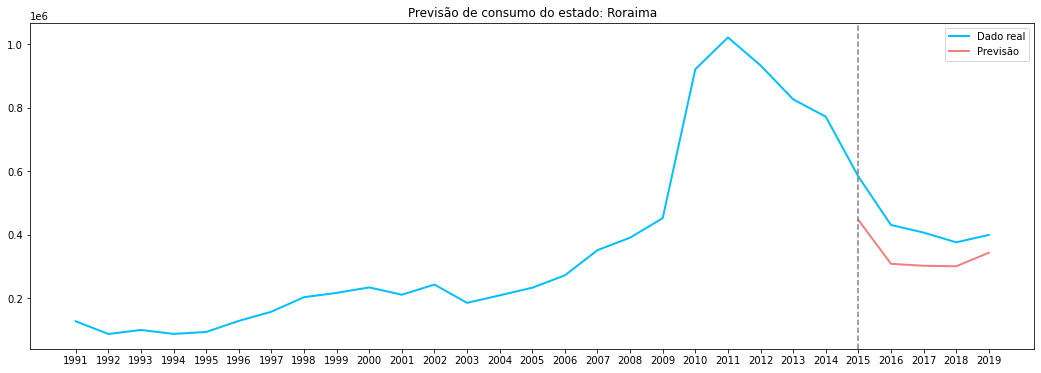

In [76]:
# previsões na região norte
for estado in NORTE:
  show_pred(estado, df_consumo, df_pred_anual)

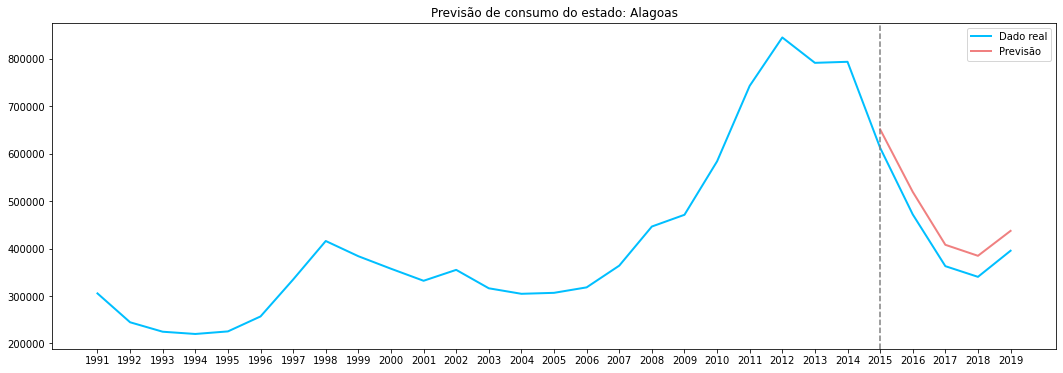

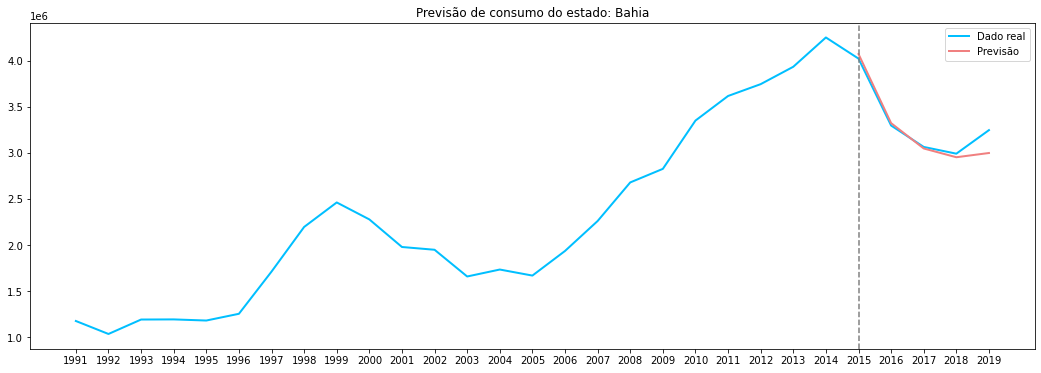

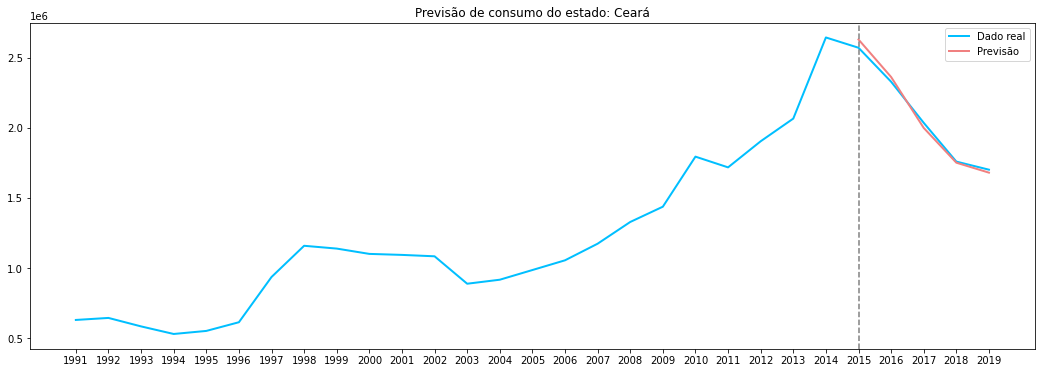

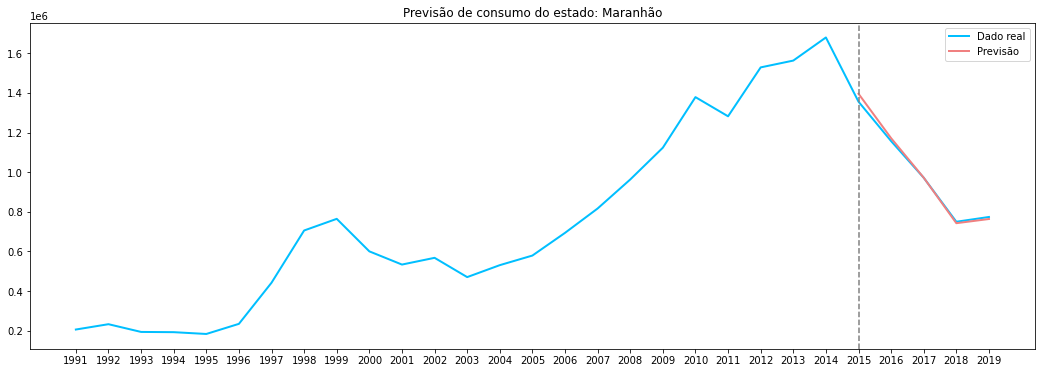

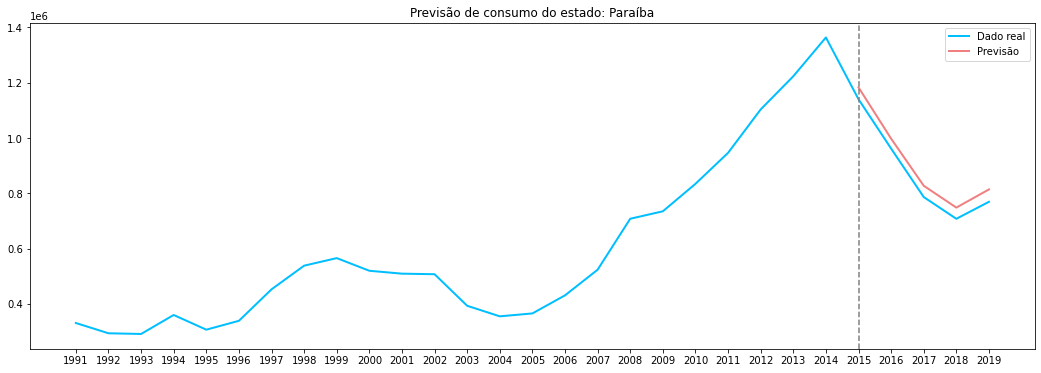

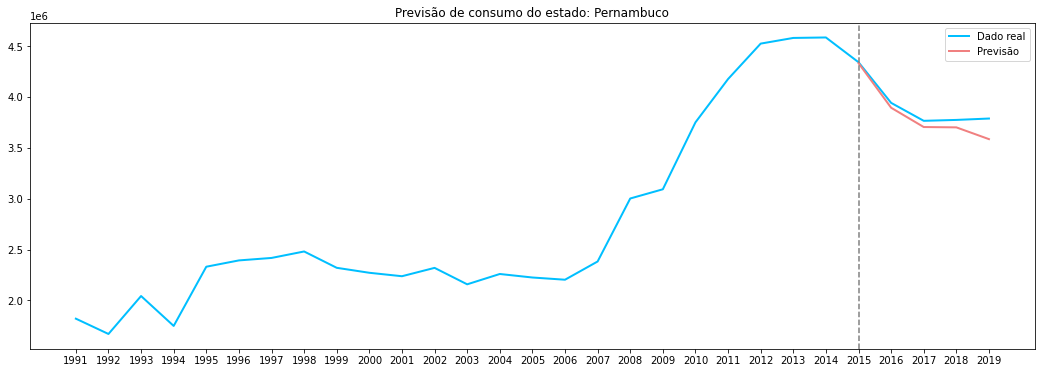

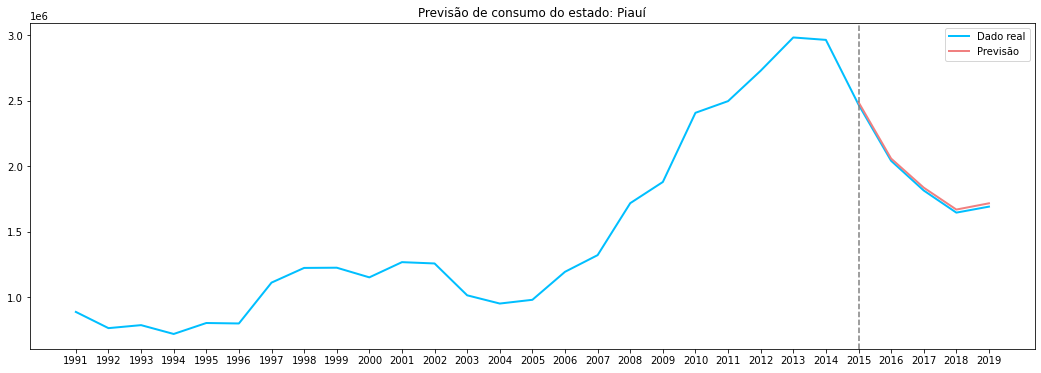

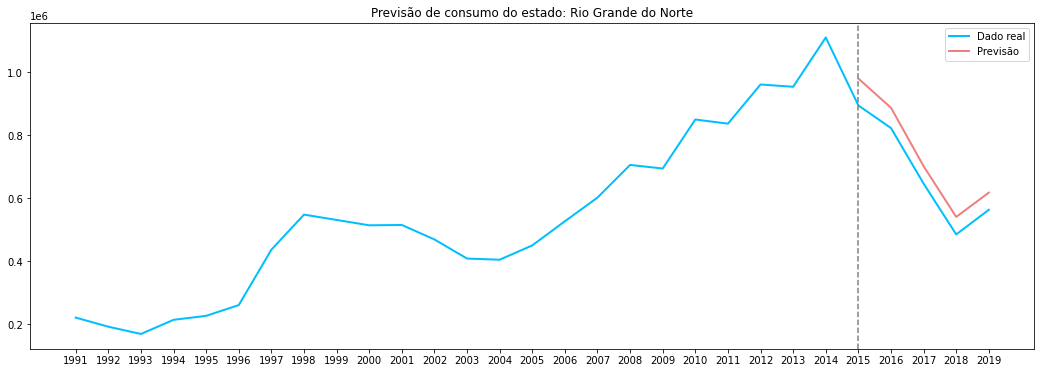

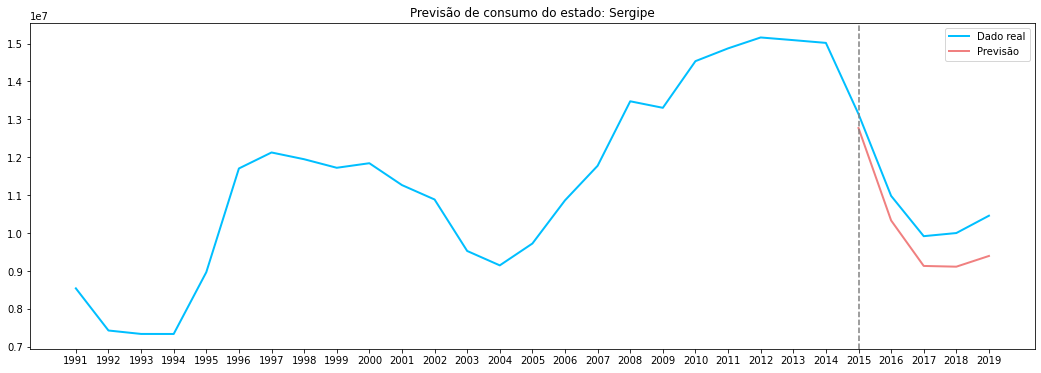

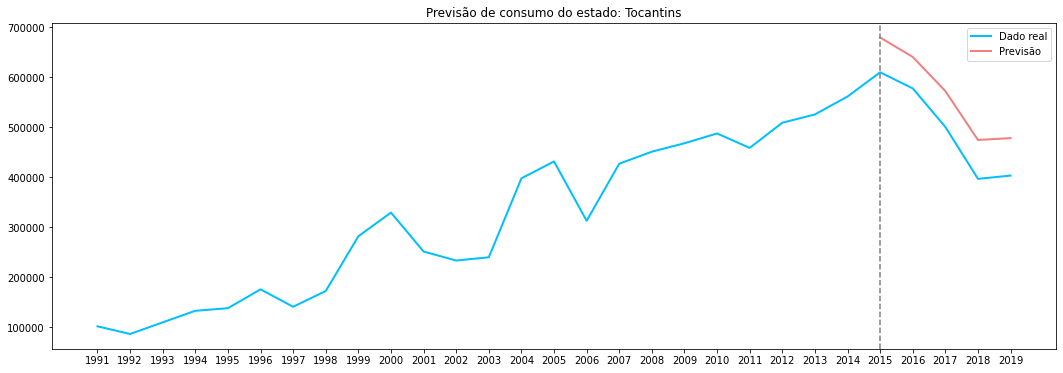

In [77]:
# previsões na região NORDESTE
for estado in NORDESTE:
  show_pred(estado, df_consumo, df_pred_anual)

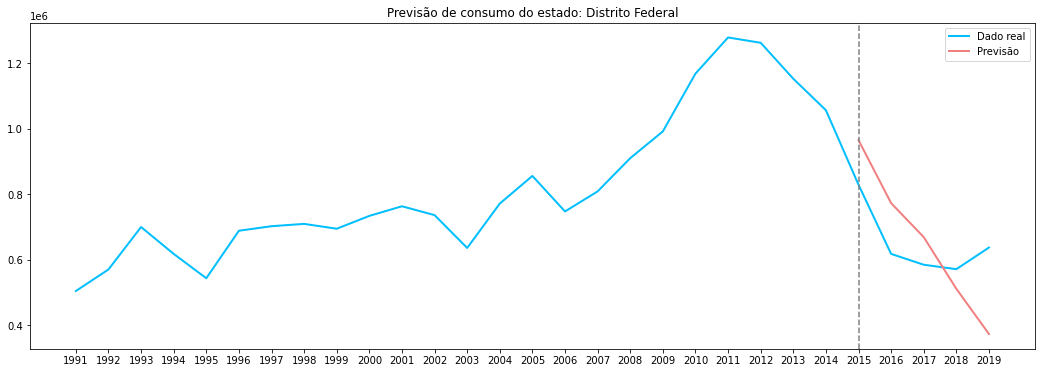

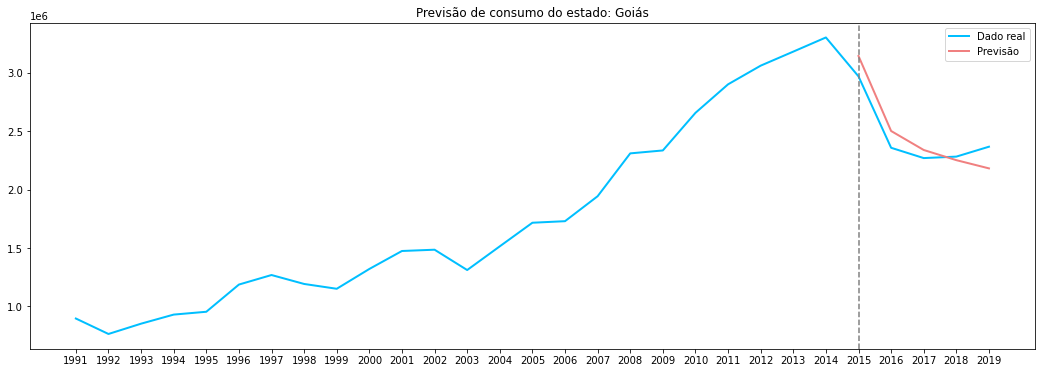

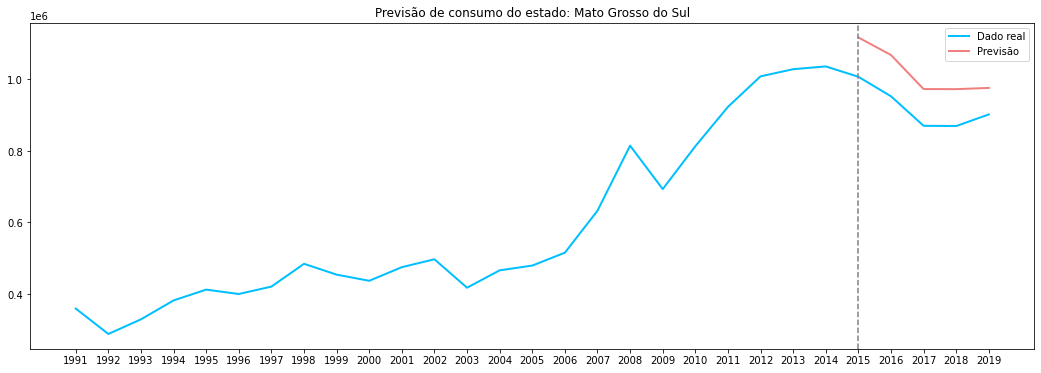

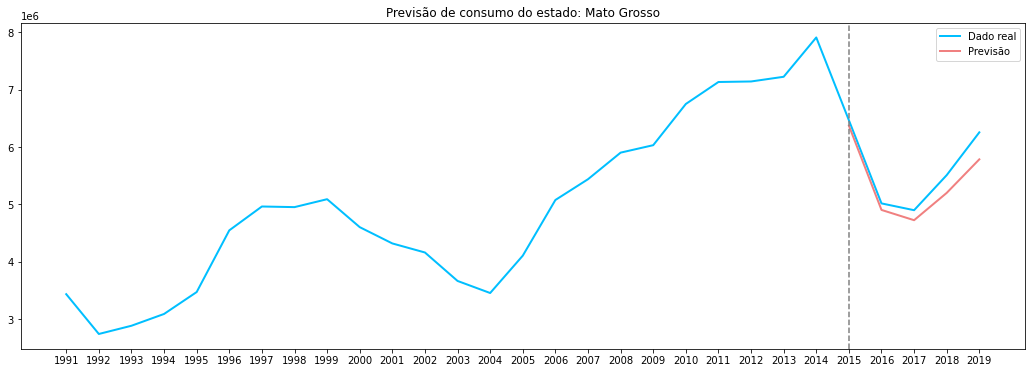

In [78]:
# previsões na região CENTRO
for estado in CENTRO:
  show_pred(estado, df_consumo, df_pred_anual)

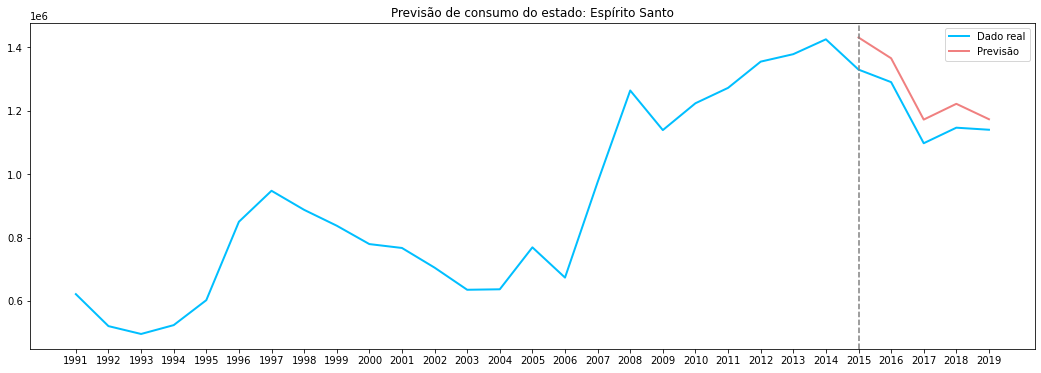

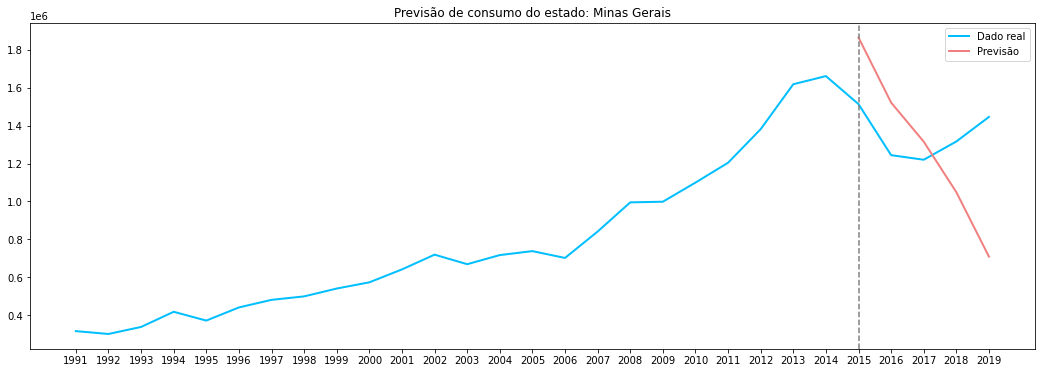

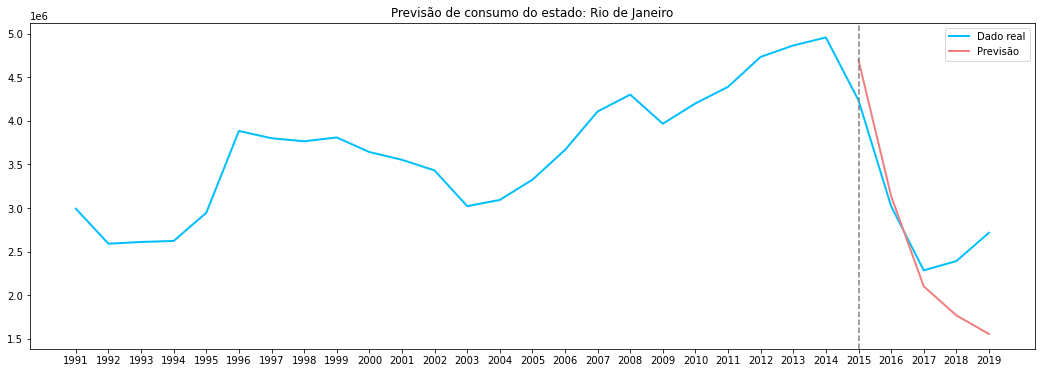

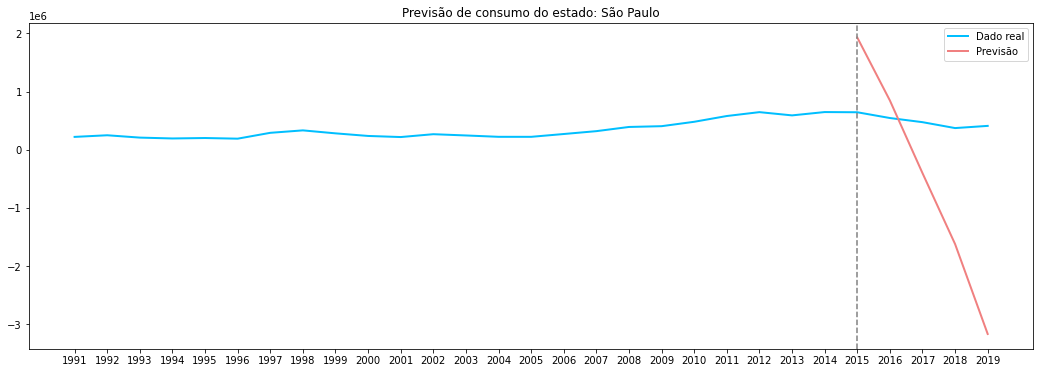

In [79]:
# previsões na região SUDESTE
for estado in SUDESTE:
  show_pred(estado, df_consumo, df_pred_anual)

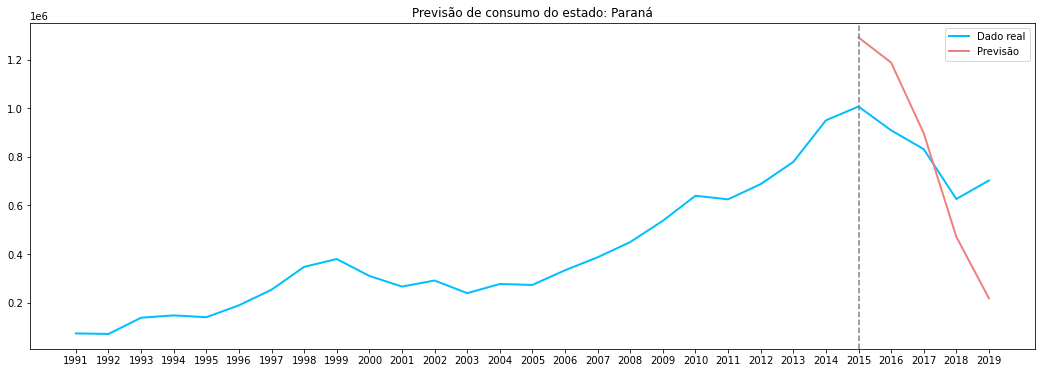

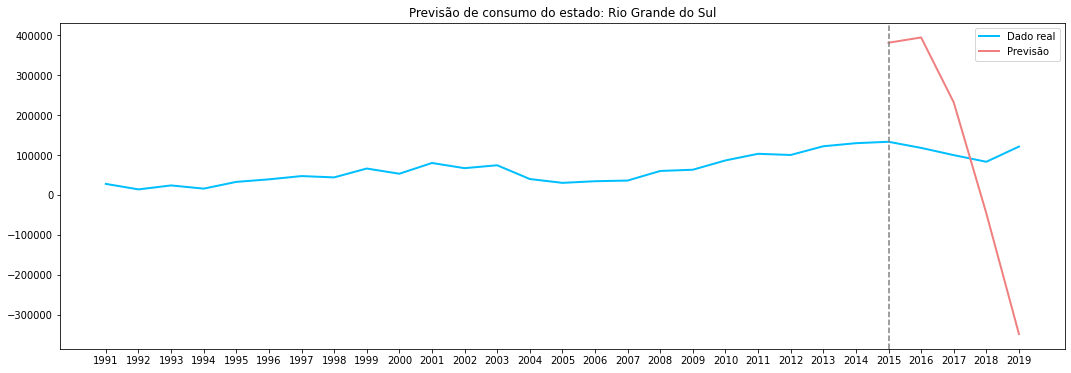

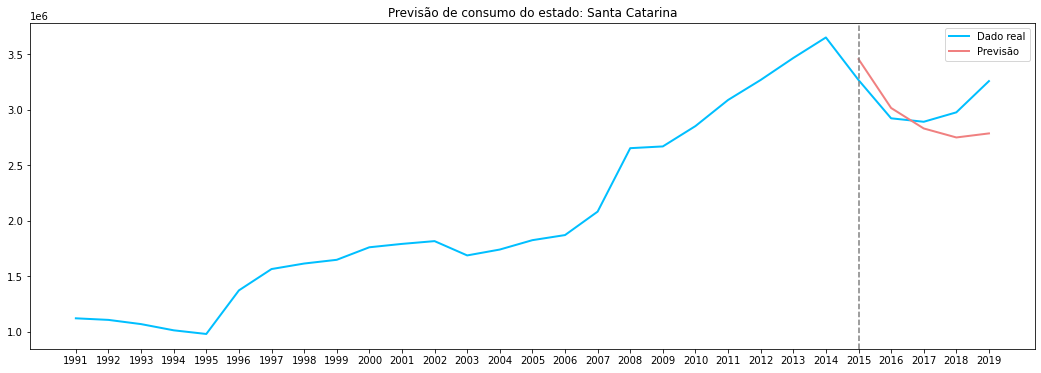

In [80]:
# previsões na região SUL
for estado in SUL:
  show_pred(estado, df_consumo, df_pred_anual)

In [81]:
from math import sqrt

error = []

for i in range(0, N_STATES):

  p = [pred_anual[j] for j in range(i,len(pred_anual),N_STATES*12)]
  t = [tendencia[j] for j in range(i+(ANO_BASE-ANO_INICIAL)*12*27,len(tendencia),N_STATES*12)]

  erro = sum([( abs(t[j]-p[j]) / t[j])**2 for j in range(len(t))])/len(t)

  print(f"[{ESTADOS[i]:20s}]: erro medio de: {100*sqrt(erro):.2f}%")

  error += [100*sqrt(erro) if erro <= 1 else 100]


[Acre                ]: erro medio de: 26.12%
[Alagoas             ]: erro medio de: 10.75%
[Amazonas            ]: erro medio de: 44.53%
[Amapá               ]: erro medio de: 7.29%
[Bahia               ]: erro medio de: 3.54%
[Ceará               ]: erro medio de: 1.56%
[Distrito Federal    ]: erro medio de: 24.19%
[Espírito Santo      ]: erro medio de: 6.16%
[Goiás               ]: erro medio de: 5.37%
[Maranhão            ]: erro medio de: 1.62%
[Minas Gerais        ]: erro medio de: 28.68%
[Mato Grosso do Sul  ]: erro medio de: 11.07%
[Mato Grosso         ]: erro medio de: 4.65%
[Pará                ]: erro medio de: 2.43%
[Paraíba             ]: erro medio de: 4.94%
[Pernambuco          ]: erro medio de: 2.70%
[Piauí               ]: erro medio de: 1.18%
[Paraná              ]: erro medio de: 37.88%
[Rio de Janeiro      ]: erro medio de: 23.26%
[Rio Grande do Norte ]: erro medio de: 9.50%
[Rondônia            ]: erro medio de: 0.42%
[Roraima             ]: erro medio de: 22.88%
[

In [82]:
df_error = pd.DataFrame(error, index = SIGLAS, columns = ["erro"])
df_error["estados"] = SIGLAS
df_error["regiao"] = REGIAO

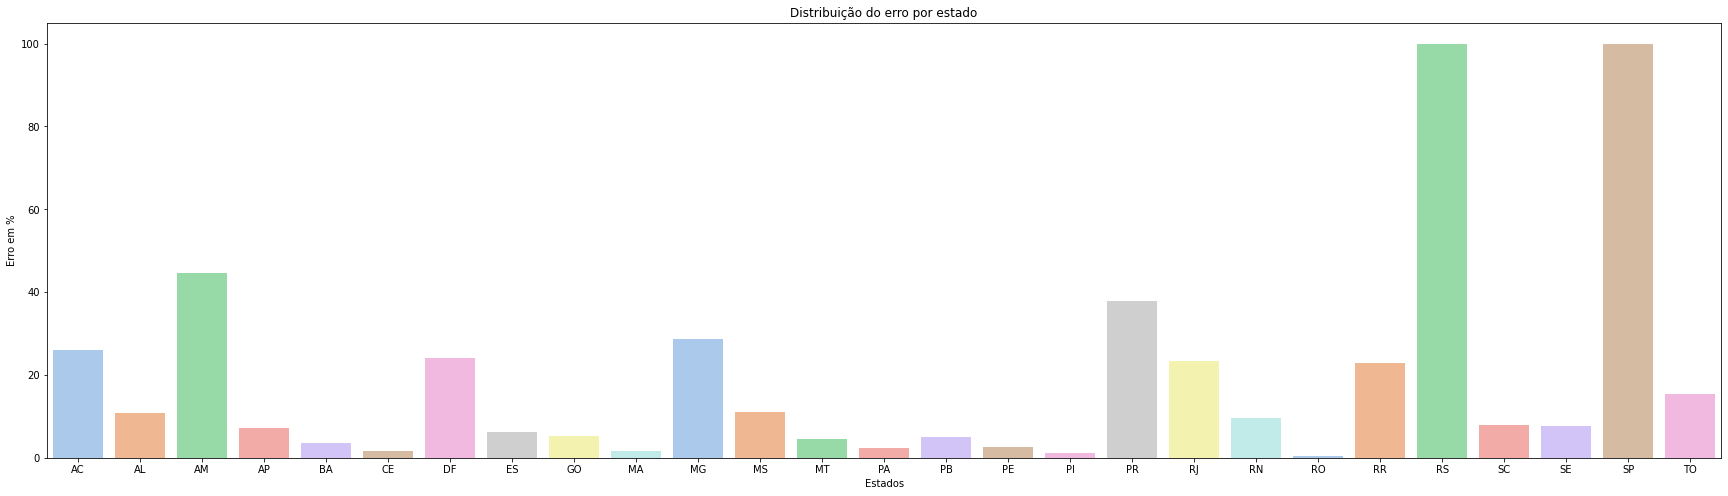

In [83]:
# sns.color_palette("Pastel")

plt.figure(figsize=(30,8))
sns.barplot(data=df_error, y="erro", x="estados", orient="v", palette="pastel")

plt.xlabel("Estados")
plt.ylabel("Erro em %")
plt.title("Distribuição do erro por estado")

plt.show()

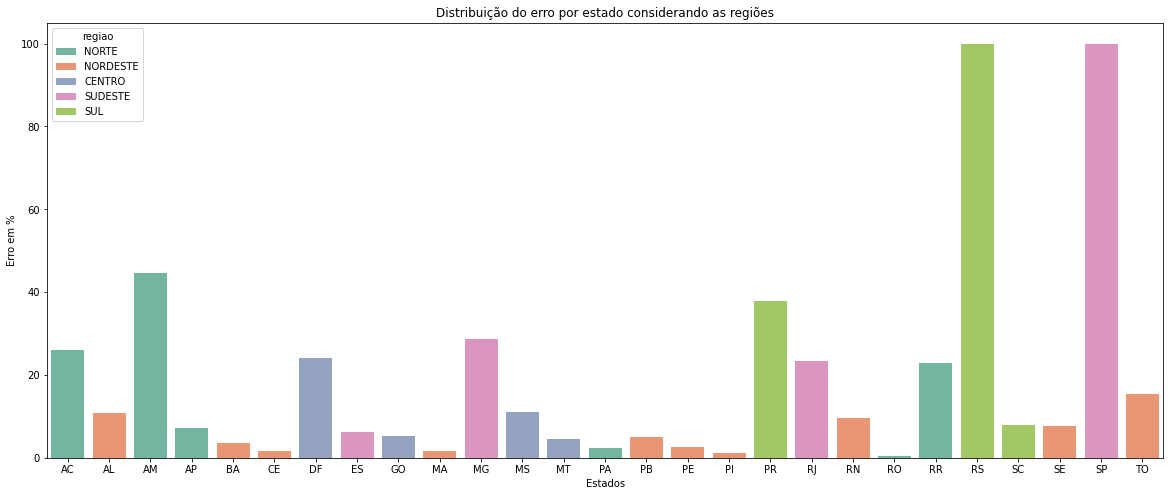

In [84]:
plt.figure(figsize=(20,8))
sns.barplot(data=df_error, y="erro", x="estados", orient="v", hue="regiao", dodge=False, palette="Set2")

plt.xlabel("Estados")
plt.ylabel("Erro em %")
plt.title("Distribuição do erro por estado considerando as regiões")

plt.show()